# 实验五：层次聚类

> 姓名：王茂增\
> 学号：2113972\
> 专业：计算机科学与技术\
> 代码：https://github.com/mzwangg/MachineLearning

- 基本要求
    - 绘制聚类前后样本分布情况 
        - 实现 single-linkage 层次聚类算法；
        - 实现 complete-linkage 层次聚类算法。
- 中级要求：
    - 实现 average-linkage 层次聚类算法，绘制样本分布图。
- 提高要求：
    - 对⽐上述三种算法，给出结论。
- 拓展要求：
    - 通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析。


## 导入需要的包

In [15]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

1. 忽略警告信息，使其不显示在控制台上。
2. 设置Matplotlib的字体为宋体（SimHei），以显示中文字符。
3. 设置Matplotlib不显示负号为Unicode字符，以确保正确显示负号。

In [16]:
warnings.filterwarnings("ignore") # 不显示warning
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 显示负号

## 读取、显示数据

In [17]:
# 绘制样本分布图
def plot_samples(data, labels, title):
    # 绘制3D散点图
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='viridis')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title(title)
    plt.show()

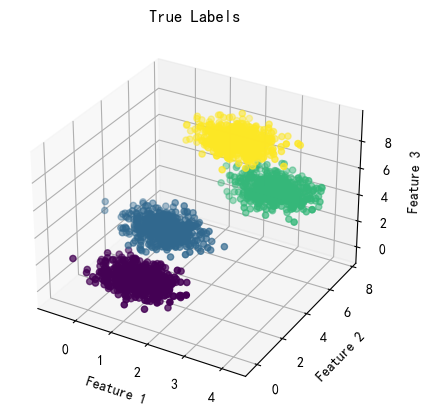

In [18]:
# 读取数据和标签
data = np.loadtxt('data.dat')
true_labels = np.loadtxt('label.dat').astype(int)

# 绘制聚类前的样本分布图
plot_samples(data, true_labels, 'True Labels')

## 基本要求+中级要求

### 距离更新算法

使用`singleLinkage`、`completeLinkage`、`averageLinkage`三种距离更新算法，更新距离矩阵。对三种方法的分析见提高要求。

In [19]:
def singleLinkage(X,_):
    return np.min(X, axis=0)

def completeLinkage(X,_):
    return np.max(X, axis=0)

def averageLinkage(X, num):
    return np.average(X, axis=0, weights = num)

### 层次聚类

该代码实现了层次聚类算法，其中 `data` 是输入的数据集，`k` 是目标簇的个数，func` 是用于计算合并两个聚类的距离的函数。首先，通过计算距离矩阵初始化每个点与其他点的距离。然后，通过不断合并最相似的两个聚类，更新距离矩阵和聚类簇，直到达到目标簇的个数。最后，为每个样本分配簇标签。

对于聚类间距离矩阵更新，当合并两个类别时，距离矩阵只有两行两列需要改变，i行i列使用func更新距离矩阵，j行j列可直接删除，由此通过一层循环就能实现层次聚类。

In [20]:
def hierarchical_clustering(data, func, max_k=10):
    """
    层次聚类算法

    Parameters:
    - data: 数据集，每一行是一个数据点
    - k: 聚类的数量
    - func: 聚类间距离更新函数，接受两个参数
    （两个聚类的距离矩阵各自的数据点数量, 作为averageLinkage的权重）

    Returns:
    - labels: 每个数据点所属的聚类标签
    """
    # 存储聚类结果
    n = len(data)
    labels = np.zeros((max_k+1,n), dtype=int)

    # 计算距离矩阵
    distances = np.linalg.norm(data[:, np.newaxis, :] - data, axis=2)
    np.fill_diagonal(distances, 1e10)

    # 初始化簇，每个数据点初始化为一个簇
    clusters = [[i] for i in range(n)]

    # 开始合并簇
    clusterCount = n
    while clusterCount != 1:
        # 寻找最相似的两个聚类
        min_distance_index = np.argmin(distances)
        i, j = divmod(min_distance_index, clusterCount)

        # 聚类间距离矩阵更新
        # 当合并两个类别时，距离矩阵只有两行两列需要改变
        # i行i列使用func更新距离矩阵
        # j行j列可直接删除
        modify = func(distances[[i, j]], (len(clusters[i]), len(clusters[j])))
        distances[i, :] = modify
        distances[:, i] = modify
        distances = np.delete(distances, j, axis=0)
        distances = np.delete(distances, j, axis=1)
        distances[i, i] = 1e10

        # 聚类更新
        clusters[i] = clusters[i] + clusters[j]
        del clusters[j]
        clusterCount -= 1

        if clusterCount <= max_k:
            # 为每个点分配簇标签
            for i, cluster in enumerate(clusters):
                labels[clusterCount, cluster] = i

    return labels

### 聚类性能指标

**调整兰德指数 (Adjusted Rand Index, ARI)** 是一种用于度量两个聚类结果之间的相似性的外部聚类评估指标。它考虑了数据中的随机性，对标准兰德指数进行了修正，使其对随机聚类的影响降到最低。

ARI 的取值范围在 -1 到 1 之间，其中：

- ARI = 1 表示两个聚类结果完全一致。
- ARI = 0 表示两个聚类结果之间的一致性与随机聚类相当。
- ARI 小于 0 表示两个聚类结果之间的一致性差于随机聚类。

为了计算ARI的值，引入contingency table (列联表)，反映实例类别划分与聚类划分的重叠程度，表的行表示实际划分的类别，表的列表示聚类划分的簇标记，nij表示重叠实例数量，如下所示:

|  | 簇 1 | 簇 2 | $\ldots$ | 簇 $\mathrm{s}$ | 求和 |
| :--- | :---: | :---: | :---: | :---: | :---: |
| 类别 1 | $\mathrm{n} 11$ | $\mathrm{n} 12$ | $\ldots$ | $\mathrm{n} 1s$ | $\mathrm{a} 1$ |
| 类别 2 | $\mathrm{n} 21$ | $\mathrm{n} 22$ | $\ldots$ | $\mathrm{n} 2s$ | $\mathrm{a} 2$ |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |
| 类别 r | $\mathrm{n} r1$ | $\mathrm{n} r2$ | $\ldots$ | $\mathrm{n} rs$ | $\mathrm{a} r$ |
| 求和 | $\mathrm{b} 1$ | $\mathrm{b} 2$ | $\ldots$ | $\mathrm{bs}$ |  |

有了列联表，即可用它计算ARI:
$$
A R I=\frac{\sum_{i j}\left(\begin{array}{c}
n_{i j} \\
2
\end{array}\right)-\left[\sum_i\left(\begin{array}{c}
a_i \\
2
\end{array}\right) \sum_j\left(\begin{array}{c}
b_j \\
2
\end{array}\right)\right] /\left(\begin{array}{c}
n \\
2
\end{array}\right)}{\frac{1}{2}\left[\sum_i\left(\begin{array}{c}
a_i \\
2
\end{array}\right)+\sum_j\left(\begin{array}{c}
b_j \\
2
\end{array}\right)\right]-\left[\sum_i\left(\begin{array}{c}
a_i \\
2
\end{array}\right) \sum_j\left(\begin{array}{c}
b_j \\
2
\end{array}\right)\right] /\left(\begin{array}{c}
n \\
2
\end{array}\right)}
$$

In [21]:
def my_adjusted_rand_index(true_labels, pred_labels):
    """
    计算调整兰德指数

    Parameters:
    - true_labels: 真实的标签
    - pred_labels: 预测的标签

    Returns:
    - adjusted_rand_index: 调整兰德指数
    """
    # 构建 contingency table（列为真实类别，行为预测类别）
    contingency_table = np.zeros((np.max(true_labels) + 1, np.max(pred_labels) + 1), dtype=int)

    # 填充 contingency table
    for true, pred in zip(true_labels, pred_labels):
        contingency_table[true, pred] += 1

    # 计算组内匹配对数
    a = np.sum(contingency_table * (contingency_table - 1)) / 2
    # 计算真实类别的匹配对数
    b = np.sum(np.sum(contingency_table, axis=1) * (np.sum(contingency_table, axis=1) - 1)) / 2
    # 计算预测类别的匹配对数
    c = np.sum(np.sum(contingency_table, axis=0) * (np.sum(contingency_table, axis=0) - 1)) / 2
    # 计算总的匹配对数
    n = len(true_labels) * (len(true_labels) - 1) / 2

    # 计算调整兰德指数
    expected_index = (b * c) / n
    max_index = (b + c) / 2
    adjusted_rand_index = (a - expected_index) / (max_index - expected_index)

    return adjusted_rand_index

这段代码实现了计算**聚类准确率**的功能。首先，通过断言确保预测簇的大小与真实标签的大小相同。然后，确定簇的数量，假设簇的标签是从0开始的整数，以便初始化混淆矩阵。接下来，通过遍历真实标签和预测簇的对应关系，填充混淆矩阵。使用linear_sum_assignment函数来找到混淆矩阵的最佳匹配，该函数使用匈牙利算法进行最小权重匹配。最后，通过计算正确匹配的样本数量占总样本数量的比例来得到聚类准确率。

In [22]:
from scipy.optimize import linear_sum_assignment

def my_clustering_accuracy(y_true, y_pred):
    """
    计算聚类准确率

    Parameters:
    - y_true: 真实标签
    - y_pred: 预测簇

    Returns:
    - accuracy: 聚类准确率
    """
    # 确保预测簇的大小与真实标签的大小相同
    assert y_pred.size == y_true.size

    # 获取簇的数量，这里假设簇的标签是从0开始的整数
    D = max(y_pred.max(), y_true.max()) + 1

    # 初始化并填充混淆矩阵
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    # 使用匈牙利算法找到最佳匹配
    row_ind, col_ind = linear_sum_assignment(w.max() - w)

    # 计算准确率
    accuracy = sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size
    
    return accuracy

### 计算得分

In [23]:
# 使用sklearn的调整兰德指数与本人实现的进行对照
# 以验证本人实现的整兰德指数的正确性
from sklearn import metrics

def cal_scores(name, true_labels, pred_labels):
    print(name, ":")
    print("My Adjusted Rand Index:", my_adjusted_rand_index(true_labels ,pred_labels))
    print("Sklearn Adjusted Rand Index:", metrics.adjusted_rand_score(true_labels, pred_labels))
    print("My Clustering Accuracy:", my_clustering_accuracy(true_labels, pred_labels))

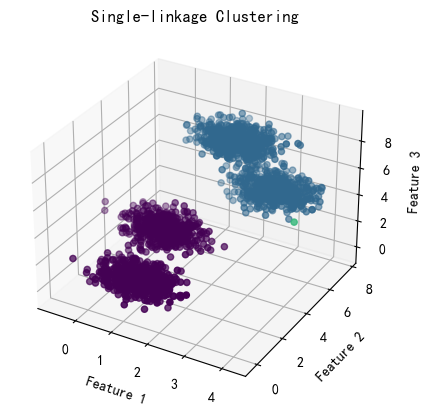

Single-linkage :
My Adjusted Rand Index: 0.4991262838267789
Sklearn Adjusted Rand Index: 0.4991262838267789
My Clustering Accuracy: 0.5005


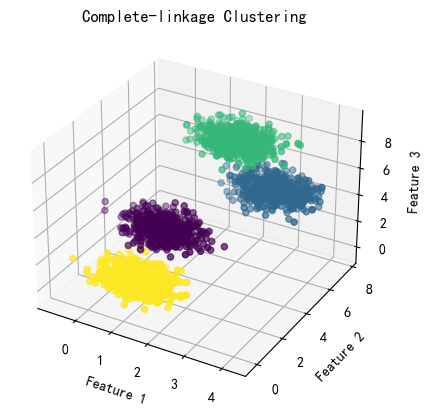

Complete-linkage :
My Adjusted Rand Index: 0.9960060300478792
Sklearn Adjusted Rand Index: 0.9960060300478792
My Clustering Accuracy: 0.9985


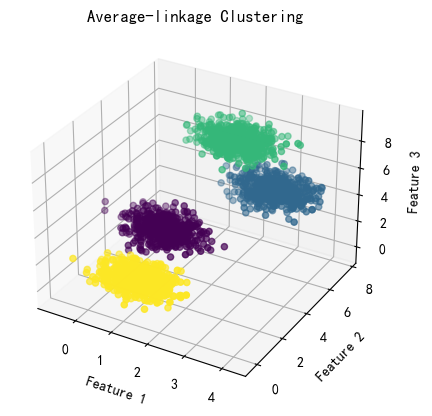

Average-linkage :
My Adjusted Rand Index: 0.9986659988879995
Sklearn Adjusted Rand Index: 0.9986659988879995
My Clustering Accuracy: 0.9995


In [24]:
# 保留10类及以下的聚类结果
MAX_CLUSTER_NUM = 10

# Single-linkage 聚类
single_linkage_labels = hierarchical_clustering(data, singleLinkage, MAX_CLUSTER_NUM)
# 绘制聚类后的样本分布图
plot_samples(data, single_linkage_labels[4], 'Single-linkage Clustering')
cal_scores("Single-linkage", true_labels, single_linkage_labels[4])

# Complete-linkage 聚类
complete_linkage_labels = hierarchical_clustering(data, completeLinkage, MAX_CLUSTER_NUM)
# 绘制聚类后的样本分布图
plot_samples(data, complete_linkage_labels[4], 'Complete-linkage Clustering')
cal_scores("Complete-linkage", true_labels, complete_linkage_labels[4])

# Average-linkage 聚类
average_linkage_labels = hierarchical_clustering(data, averageLinkage, MAX_CLUSTER_NUM)
# 绘制聚类后的样本分布图
plot_samples(data, average_linkage_labels[4], 'Average-linkage Clustering')
cal_scores("Average-linkage", true_labels, average_linkage_labels[4])

## 提高要求

1. **Single-Linkage 层次聚类算法：**
   - **连接策略：** 也称为最小距离法，它计算两个簇之间所有成员之间的最小距离，然后将这个最小距离作为这两个簇之间的距离。
   - **计算公式：** $d(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} \text{dist}(\mathbf{x}, \mathbf{y})$
   - **特点：** Single-Linkage 倾向于形成具有长条形状的簇，对异常值敏感。

2. **Complete-Linkage 层次聚类算法：**
   - **连接策略：** 也称为最大距离法，它计算两个簇之间所有成员之间的最大距离，然后将这个最大距离作为这两个簇之间的距离。
   - **计算公式：** $d(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} \text{dist}(\mathbf{x}, \mathbf{y})$
   - **特点：** Complete-Linkage 通常产生紧凑且密集的簇，对离群点相对较不敏感。

3. **Average-Linkage 层次聚类算法：**
   - **连接策略：** 它计算两个簇之间所有成员之间的平均距离，然后将这个平均距离作为这两个簇之间的距离。
   - **计算公式：** $d(C_i, C_j) = \frac{1}{|C_i| \cdot |C_j|} \sum_{\mathbf{x} \in C_i} \sum_{\mathbf{y} \in C_j} \text{dist}(\mathbf{x}, \mathbf{y})$
   - **特点：** Average-Linkage 综合了 Single-Linkage 和 Complete-Linkage 的特性，通常产生均匀且相对平衡的簇。

通过上述结果，可得出如下结论：

   - 本人实现的计算**调整兰德指数**的函数，与sklearn中计算的调整兰德指数结果相同，验证了本人实现函数的正确性。

   - 三种聚类方法中，**Single-linkage**聚类方法的结果最差，没有发现4个簇，**Complete-Linkage**和**Average-linkage**聚类方法的结果最好且差距不大，都成功发现了4个簇。

   这是由于**Single-Linkage** 倾向于形成具有长条形状的簇，对异常值敏感，所以把两个较近的簇判定为了一个簇；**Complete-Linkage** 通常产生紧凑且密集的簇，对离群点相对较不敏感，所以成功判别出了4个簇,；而**Average-Linkage** 综合了 **Single-Linkage** 和 **Complete-Linkage** 的特性，通常产生均匀且相对平衡的簇，也能区分距离较近的两个簇。

### 拓展要求

绘制3D图，比较三种聚类方法的结果。

In [25]:
def plot_samples_3(data, labels1, labels2, labels3, title1, title2, title3):
    # 创建3D图形
    fig = plt.figure(figsize=(15, 5))

    # 绘制第一个子图
    ax1 = fig.add_subplot(131, projection='3d')
    scatter1 = ax1.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels1, cmap='viridis')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.set_zlabel('Feature 3')
    ax1.set_title(title1)
    ax1.legend(*scatter1.legend_elements(), title="Classes")

    # 绘制第二个子图
    ax2 = fig.add_subplot(132, projection='3d')
    scatter2 = ax2.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels2, cmap='viridis')
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    ax2.set_zlabel('Feature 3')
    ax2.set_title(title2)
    ax2.legend(*scatter2.legend_elements(), title="Classes")

    # 绘制第三个子图
    ax3 = fig.add_subplot(133, projection='3d')
    scatter3 = ax3.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels3, cmap='viridis')
    ax3.set_xlabel('Feature 1')
    ax3.set_ylabel('Feature 2')
    ax3.set_zlabel('Feature 3')
    ax3.set_title(title3)
    ax3.legend(*scatter3.legend_elements(), title="Classes")

    # 调整布局
    plt.tight_layout()

    # 显示图形
    plt.show()

进行比较

k=2:
Single Linkage Adjusted Rand Index: 0.4996245306633291
Complete Linkage Adjusted Rand Index: 0.4996245306633291
Average Linkage Adjusted Rand Index: 0.4996245306633291
Single Linkage Accuracy: 0.5
Complete Linkage Accuracy: 0.5
Average Linkage Accuracy: 0.5


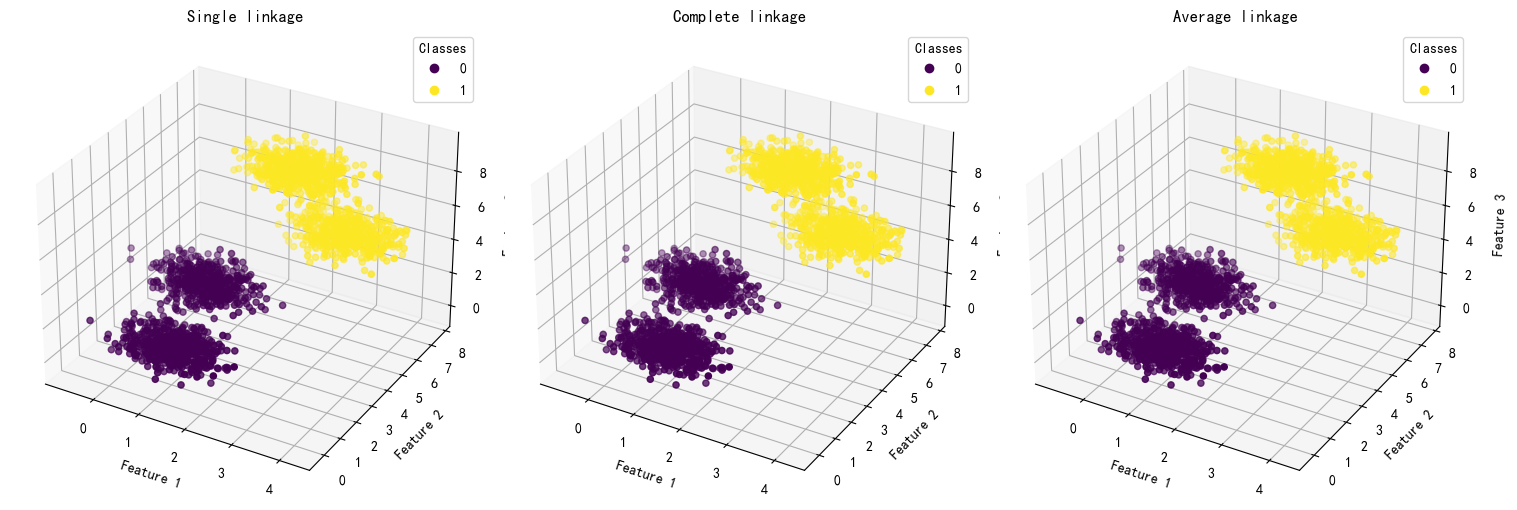

k=3:
Single Linkage Adjusted Rand Index: 0.49937490583552474
Complete Linkage Adjusted Rand Index: 0.7139791100300472
Average Linkage Adjusted Rand Index: 0.7139791100300472
Single Linkage Accuracy: 0.5005
Complete Linkage Accuracy: 0.75
Average Linkage Accuracy: 0.75


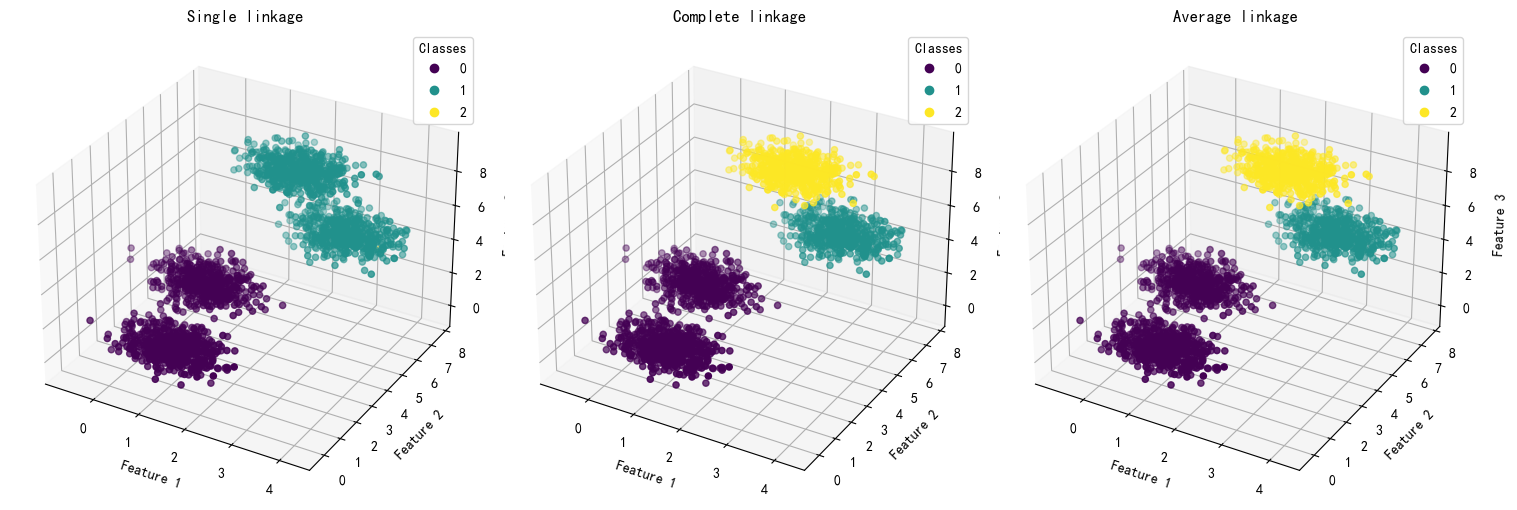

k=4:
Single Linkage Adjusted Rand Index: 0.4991262838267789
Complete Linkage Adjusted Rand Index: 0.9960060300478792
Average Linkage Adjusted Rand Index: 0.9986659988879995
Single Linkage Accuracy: 0.5005
Complete Linkage Accuracy: 0.9985
Average Linkage Accuracy: 0.9995


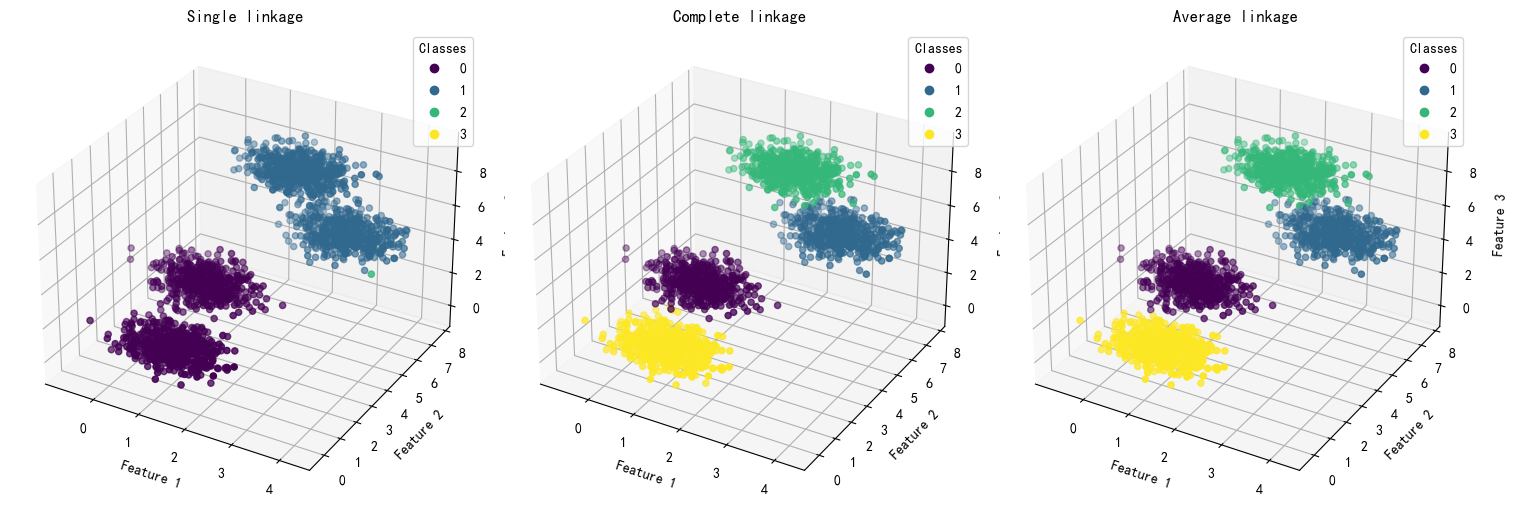

k=5:
Single Linkage Adjusted Rand Index: 0.49887615900142207
Complete Linkage Adjusted Rand Index: 0.9634700407488358
Average Linkage Adjusted Rand Index: 0.9979989983331136
Single Linkage Accuracy: 0.501
Complete Linkage Accuracy: 0.9715
Average Linkage Accuracy: 0.999


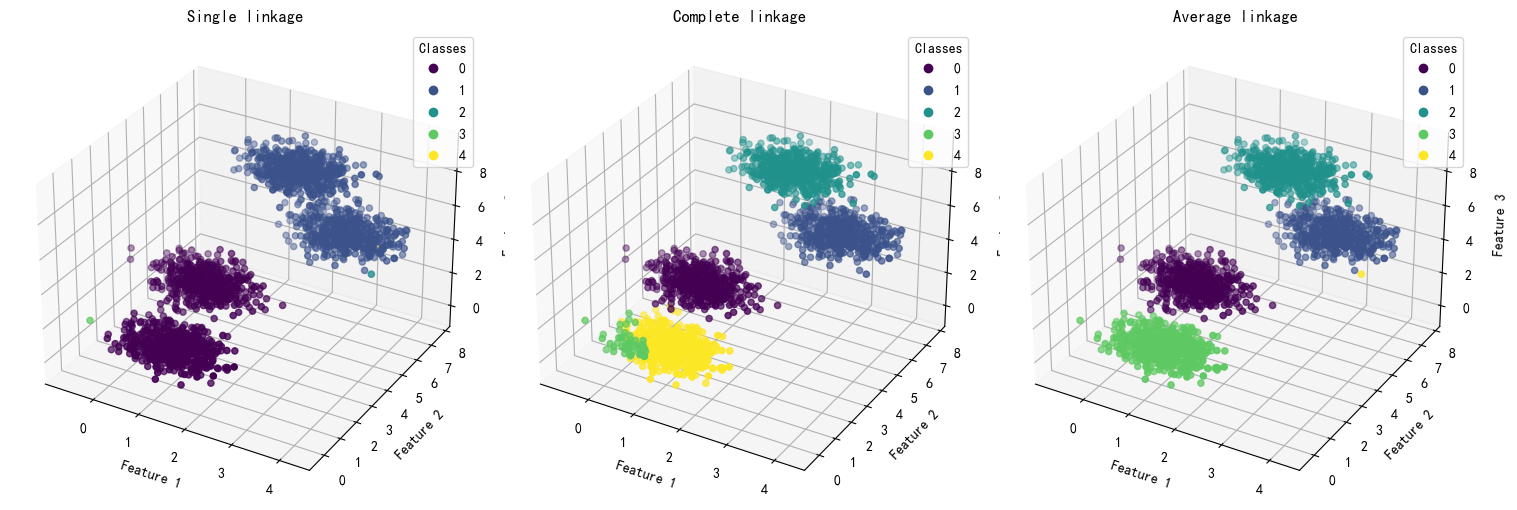

k=6:
Single Linkage Adjusted Rand Index: 0.7125108563977904
Complete Linkage Adjusted Rand Index: 0.8838542950008349
Average Linkage Adjusted Rand Index: 0.9973328903823512
Single Linkage Accuracy: 0.7495
Complete Linkage Accuracy: 0.887
Average Linkage Accuracy: 0.9985


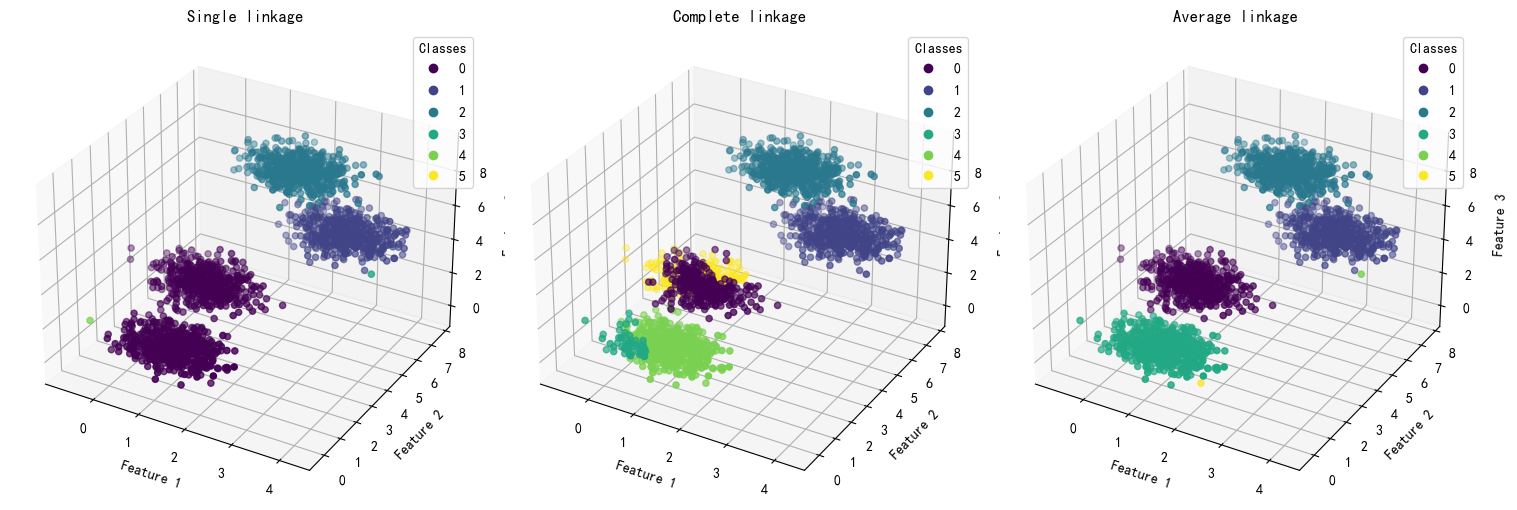

k=7:
Single Linkage Adjusted Rand Index: 0.7118568372538316
Complete Linkage Adjusted Rand Index: 0.8258095261515305
Average Linkage Adjusted Rand Index: 0.9960020107130068
Single Linkage Accuracy: 0.749
Complete Linkage Accuracy: 0.8405
Average Linkage Accuracy: 0.9975


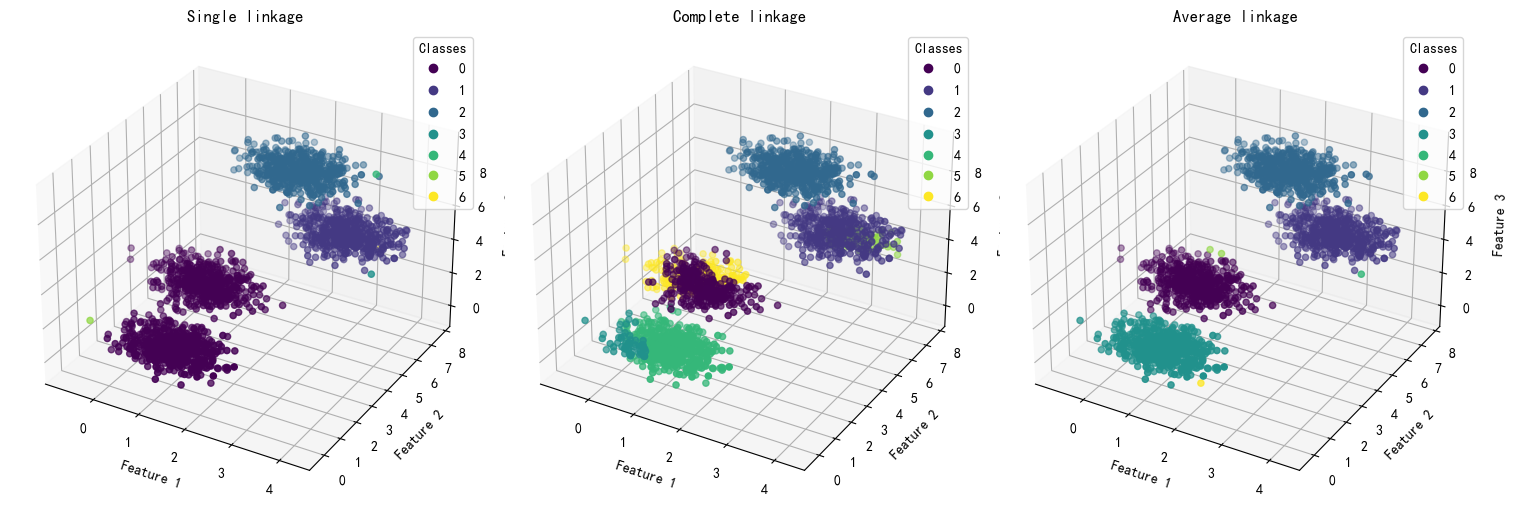

k=8:
Single Linkage Adjusted Rand Index: 0.7112037553140619
Complete Linkage Adjusted Rand Index: 0.758631639788542
Average Linkage Adjusted Rand Index: 0.9933403174955111
Single Linkage Accuracy: 0.7485
Complete Linkage Accuracy: 0.7425
Average Linkage Accuracy: 0.9955


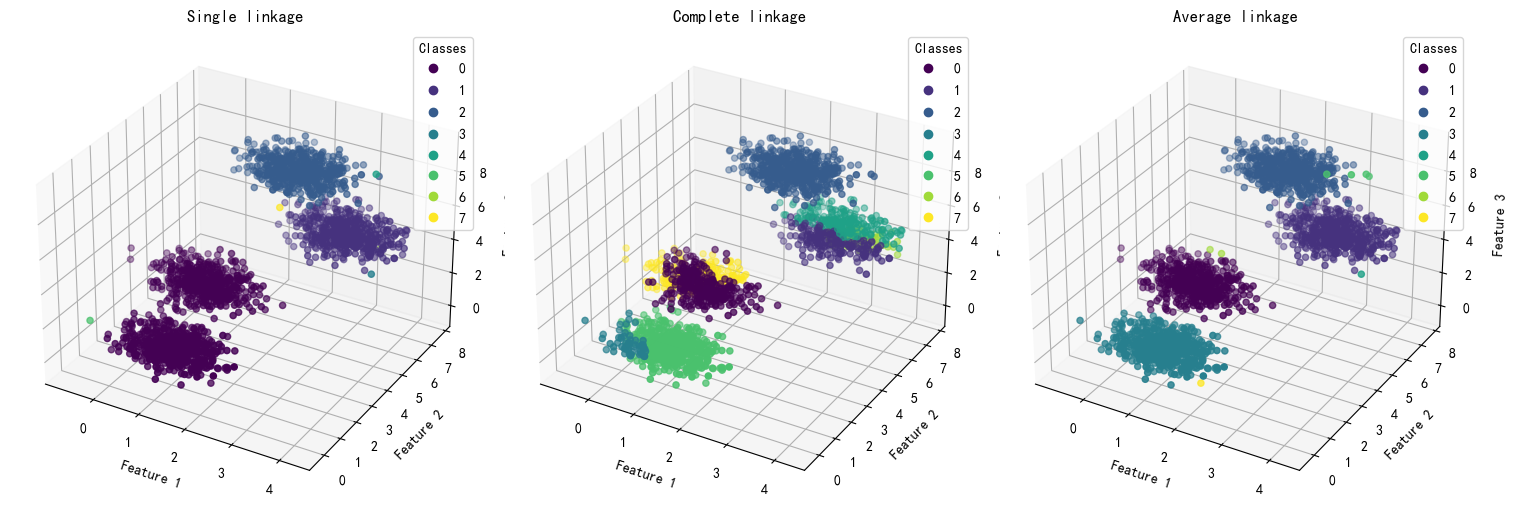

k=9:
Single Linkage Adjusted Rand Index: 0.7105516125069549
Complete Linkage Adjusted Rand Index: 0.6565932824011791
Average Linkage Adjusted Rand Index: 0.9913474374067858
Single Linkage Accuracy: 0.748
Complete Linkage Accuracy: 0.65
Average Linkage Accuracy: 0.994


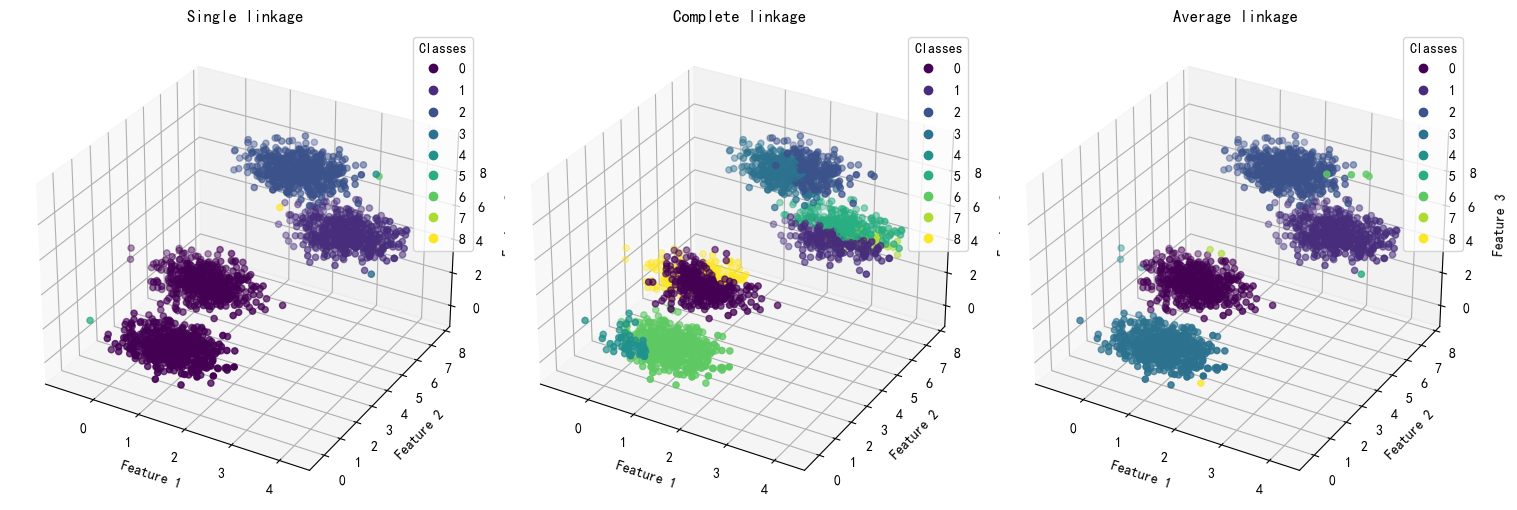

k=10:
Single Linkage Adjusted Rand Index: 0.7103856924875501
Complete Linkage Adjusted Rand Index: 0.5639539378321856
Average Linkage Adjusted Rand Index: 0.9886949218484102
Single Linkage Accuracy: 0.7475
Complete Linkage Accuracy: 0.5515
Average Linkage Accuracy: 0.992


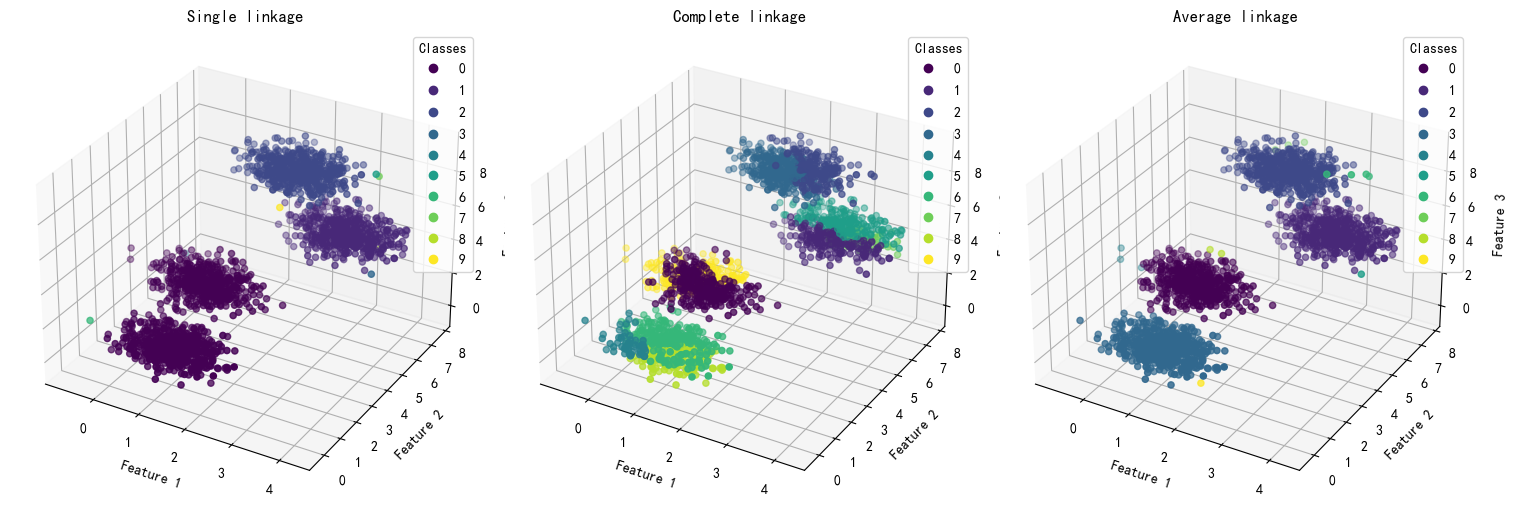

Adjusted Rand Index:
single_linkage_scores: [0.4996245306633291, 0.49937490583552474, 0.4991262838267789, 0.49887615900142207, 0.7125108563977904, 0.7118568372538316, 0.7112037553140619, 0.7105516125069549, 0.7103856924875501]
complete_linkage_scores: [0.4996245306633291, 0.7139791100300472, 0.9960060300478792, 0.9634700407488358, 0.8838542950008349, 0.8258095261515305, 0.758631639788542, 0.6565932824011791, 0.5639539378321856]
average_linkage_scores: [0.4996245306633291, 0.7139791100300472, 0.9986659988879995, 0.9979989983331136, 0.9973328903823512, 0.9960020107130068, 0.9933403174955111, 0.9913474374067858, 0.9886949218484102]
single_linkage best k: 6
complete_linkage best k: 4
average_linkage best k: 4

Clustering Accuracy:
single_linkage_scores: [0.5, 0.5005, 0.5005, 0.501, 0.7495, 0.749, 0.7485, 0.748, 0.7475]
complete_linkage_scores: [0.5, 0.75, 0.9985, 0.9715, 0.887, 0.8405, 0.7425, 0.65, 0.5515]
average_linkage_scores: [0.5, 0.75, 0.9995, 0.999, 0.9985, 0.9975, 0.9955, 0.994, 0

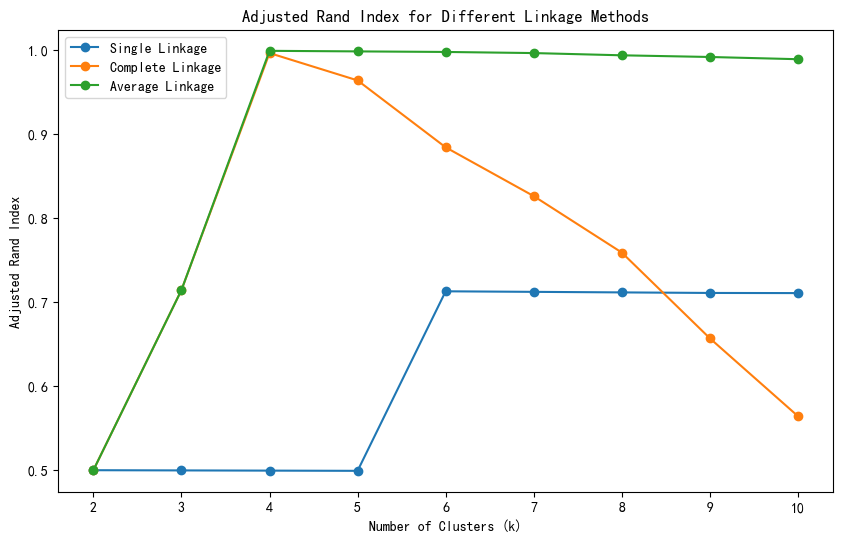

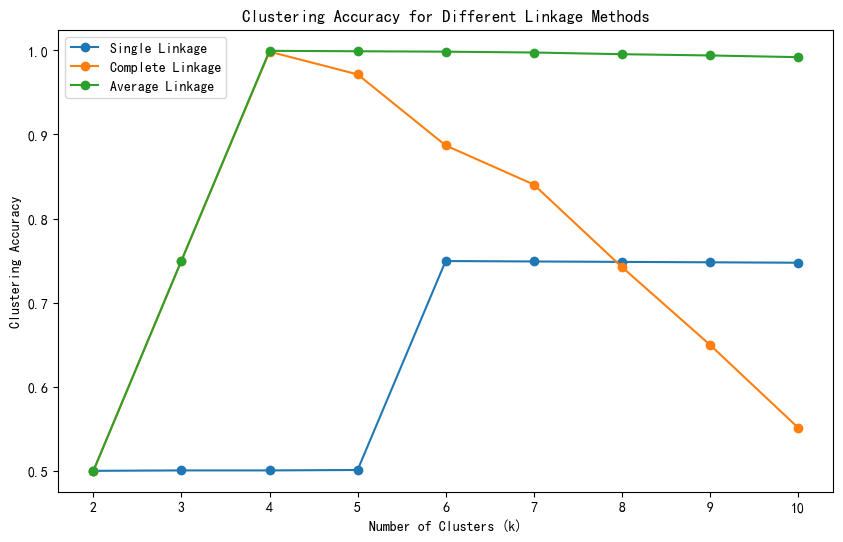

In [26]:
# 记录得分，第一个列表记录调整兰德指数，第二个列表记录准确率
single_linkage_scores = [[], []]
complete_linkage_scores = [[], []]
average_linkage_scores = [[], []]

for i in range(2, MAX_CLUSTER_NUM + 1):
    # 计算分数
    single_linkage_scores[0].append(my_adjusted_rand_index(true_labels, single_linkage_labels[i]))
    complete_linkage_scores[0].append(my_adjusted_rand_index(true_labels, complete_linkage_labels[i]))
    average_linkage_scores[0].append(my_adjusted_rand_index(true_labels, average_linkage_labels[i]))
    single_linkage_scores[1].append(my_clustering_accuracy(true_labels, single_linkage_labels[i]))
    complete_linkage_scores[1].append(my_clustering_accuracy(true_labels, complete_linkage_labels[i]))
    average_linkage_scores[1].append(my_clustering_accuracy(true_labels, average_linkage_labels[i]))

    print(f"k={i}:")
    print(f"Single Linkage Adjusted Rand Index: {single_linkage_scores[0][i - 2]}")
    print(f"Complete Linkage Adjusted Rand Index: {complete_linkage_scores[0][i - 2]}")
    print(f"Average Linkage Adjusted Rand Index: {average_linkage_scores[0][i - 2]}")
    print(f"Single Linkage Accuracy: {single_linkage_scores[1][i - 2]}")
    print(f"Complete Linkage Accuracy: {complete_linkage_scores[1][i - 2]}")
    print(f"Average Linkage Accuracy: {average_linkage_scores[1][i - 2]}")

    plot_samples_3(data, single_linkage_labels[i], complete_linkage_labels[i], average_linkage_labels[i],
               "Single linkage", "Complete linkage", "Average linkage")

print("Adjusted Rand Index:")
print("single_linkage_scores:", single_linkage_scores[0])
print("complete_linkage_scores:", complete_linkage_scores[0])
print("average_linkage_scores:", average_linkage_scores[0])
print("single_linkage best k:", np.argmax(single_linkage_scores[0]) + 2)
print("complete_linkage best k:", np.argmax(complete_linkage_scores[0]) + 2)
print("average_linkage best k:", np.argmax(average_linkage_scores[0]) + 2)

print("\nClustering Accuracy:")
print("single_linkage_scores:", single_linkage_scores[1])
print("complete_linkage_scores:", complete_linkage_scores[1])
print("average_linkage_scores:", average_linkage_scores[1])
print("single_linkage best k:", np.argmax(single_linkage_scores[1]) + 2)
print("complete_linkage best k:", np.argmax(complete_linkage_scores[1]) + 2)
print("average_linkage best k:", np.argmax(average_linkage_scores[1]) + 2)
    
# 绘制Adjusted Rand Index
k_values = list(range(2, MAX_CLUSTER_NUM+1))
plt.figure(figsize=(10, 6))
plt.plot(k_values, single_linkage_scores[0], marker='o', label='Single Linkage')
plt.plot(k_values, complete_linkage_scores[0], marker='o', label='Complete Linkage')
plt.plot(k_values, average_linkage_scores[0], marker='o', label='Average Linkage')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Adjusted Rand Index')
plt.title('Adjusted Rand Index for Different Linkage Methods')
plt.legend()
plt.show()

# 绘制Clustering Accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, single_linkage_scores[1], marker='o', label='Single Linkage')
plt.plot(k_values, complete_linkage_scores[1], marker='o', label='Complete Linkage')
plt.plot(k_values, average_linkage_scores[1], marker='o', label='Average Linkage')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Clustering Accuracy')
plt.title('Clustering Accuracy for Different Linkage Methods')
plt.legend()
plt.show()


由上述结果可知，使用**调整兰德指数**和**聚类准确率**作为指标得到的结果相似。下面对性能进行分析：

- **Complete Linkage和Average Linkage**

**2<=k<=4**: **Complete Linkage**和**Average Linkage**的性能相同且性能呈上升趋势。这是由于真实类别数为4，由样本分类图可知，当k<=4时，随着k的增加，能将更多簇正确分离出来，所以性能不断提升。

**k>4**: **Complete Linkage**性能直线下降，由样本分类图可知，随着k的增加，**Complete Linkage**将簇错误地继续拆分，导致性能的下降，甚至会低于**Single Linkage**。而**Average Linkage**的性能缓慢下降，仍然能正确区分四个簇。

- **Single Linkage**

**2<=k<=5**: **Single Linkage**仅能正确区分出两个簇，这主要是因为**Single-Linkage** 倾向于形成具有长条形状的簇，对异常值敏感。

**k>5**: **Single Linkage**能正确区分出3个簇，随着k的增加，性能甚至能超过**Complete Linkage**。